# Some coding references

Our colleague David Duvenaud created a useful [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/)

For Gaussian processes try this [scikit learn Tutorial](https://scikit-learn.org/stable/modules/gaussian_process.html)

# Combining kernels

We will present a simple example of the kernel ridge regression. This will also help us motivate combining kernels. Consider a simple situation when the ground truth is given by 
$$
y\;=\;0.2 x^2+2\sin(x)+\epsilon,\qquad \epsilon\sim N(0,1).
$$
We generate a bunch of data from this model. 

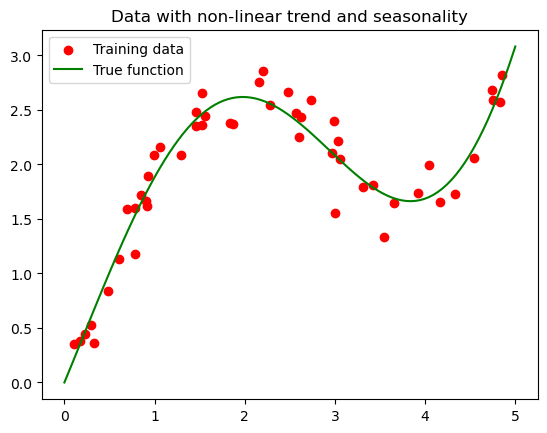

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

# Generate some synthetic data
np.random.seed(42)
X = np.sort(5 * np.random.rand(50, 1), axis=0)
y = 0.2*X.ravel()**2+2*np.sin(X).ravel()+ 0.2 * np.random.normal(size=50)

# Generate some test data
X_test = np.linspace(0, 5, 100)[:, None]


plt.scatter(X, y, c='r', label='Training data')
plt.plot(X_test, 0.2*X_test**2+2*np.sin(X_test), c='g', label='True function')
plt.legend()
plt.title('Data with non-linear trend and seasonality')
plt.show()

Without knowing the ground truth, we see that the data set has some nonlinear trend and has some oscillations. It should be a bad idea but let's try to fit a linear kernel regression to it. 

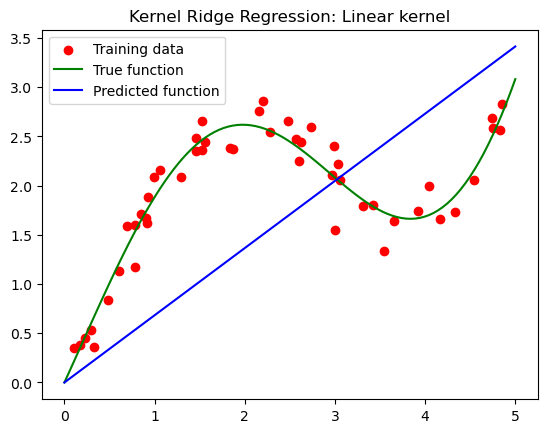

In [2]:
# Define the kernel ridge regression model with a linear kernel
kr = KernelRidge(kernel='linear', alpha=0.1, gamma=1.0)

# Fit the model to the data
kr.fit(X, y)


# Make predictions on the test data
y_pred = kr.predict(X_test)

# Plot the true function and the predicted function
plt.scatter(X, y, c='r', label='Training data')
plt.plot(X_test, 0.2*X_test**2+2*np.sin(X_test), c='g', label='True function')
plt.plot(X_test, y_pred, c='b', label='Predicted function')
plt.legend()
plt.title('Kernel Ridge Regression: Linear kernel')
plt.show()

Indeed a bad idea! How about the Gaussian kernel?


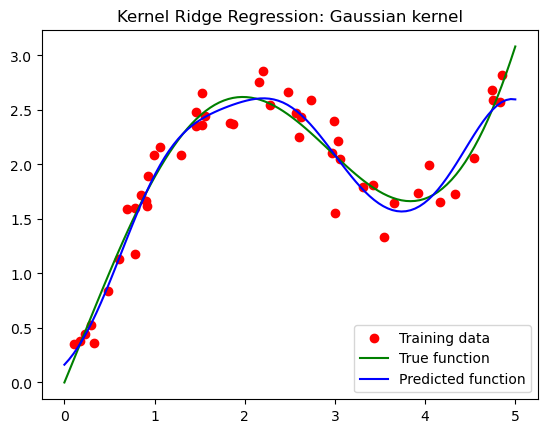

In [3]:
# Define the kernel ridge regression model with a Gaussian (RBF) kernel
kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=1.0)

# Fit the model to the data
kr.fit(X, y)


# Make predictions on the test data
y_pred = kr.predict(X_test)

# Plot the true function and the predicted function
plt.scatter(X, y, c='r', label='Training data')
plt.plot(X_test, 0.2*X_test**2+2*np.sin(X_test), c='g', label='True function')
plt.plot(X_test, y_pred, c='b', label='Predicted function')
plt.legend()
plt.title('Kernel Ridge Regression: Gaussian kernel')
plt.show()

This actually looks quite good but the predictions for $x>5$ are likely to be quite bad. Here a modeller should think about the nature of the data and propose a kernel that combines the oscilattory and non-linear trend nature of the data. 

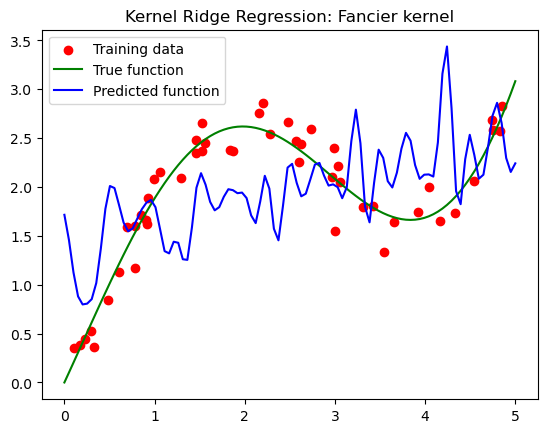

In [4]:
from sklearn.gaussian_process.kernels import DotProduct, ExpSineSquared, RBF, ConstantKernel, Product

# Define the kernels
k1 = ExpSineSquared(length_scale=1.0, periodicity=1.0)
k2 = ConstantKernel(1.0) * DotProduct()

# Define the kernel ridge regression model with a Gaussian (RBF) kernel
kr = KernelRidge(kernel=Product(k1, k2), alpha=0.1,degree=2)

# Fit the model to the data
kr.fit(X, y)


# Make predictions on the test data
y_pred = kr.predict(X_test)

# Plot the true function and the predicted function
plt.scatter(X, y, c='r', label='Training data')
plt.plot(X_test, 0.2*X_test**2+2*np.sin(X_test), c='g', label='True function')
plt.plot(X_test, y_pred, c='b', label='Predicted function')
plt.legend()
plt.title('Kernel Ridge Regression: Fancier kernel')
plt.show()

But perhaps I can learn the hyperparameters from the data?

Best hyperparameters:  {'kernel__k1__length_scale': 1.0, 'kernel__k1__periodicity': 10.0}


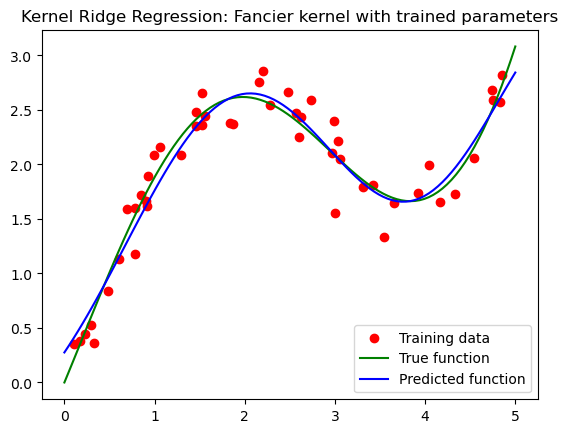

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, DotProduct,ConstantKernel, Product
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

# Generate some synthetic data
np.random.seed(42)
X = np.sort(5 * np.random.rand(50, 1), axis=0)
y = 0.2*X.ravel()**2+2*np.sin(X).ravel()+ 0.2 * np.random.normal(size=50)

# Generate some test data
X_test = np.linspace(0, 5, 100)[:, None]

# Define the kernels
k1 = ExpSineSquared(length_scale=1.0, periodicity=1.0)
k2 = ConstantKernel(1.0) * DotProduct()
kernel = Product(k1, k2)

# Define the parameter grid for the kernel hyperparameters
param_grid = {'kernel__k1__length_scale': [0.1, 1.0, 10.0],
              'kernel__k1__periodicity': [0.1, 1.0, 10.0]}

# Define the kernel ridge regression model with a Gaussian (RBF) kernel
kr = KernelRidge(kernel=kernel)

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(kr, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Make predictions on the test data using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Plot the true function and the predicted function
plt.scatter(X, y, c='r', label='Training data')
plt.plot(X_test, 0.2*X_test**2+2*np.sin(X_test), c='g', label='True function')
plt.plot(X_test, y_pred, c='b', label='Predicted function')
plt.legend()
plt.title('Kernel Ridge Regression: Fancier kernel with trained parameters')
plt.show()

# Linear algebra of the kernel trick 

Assume $\lambda>0$ and let
$$
E(w)=\tfrac12\|y-\Psi w\|^2+\tfrac{\lambda}{2}w^\top w.
$$
Then 
$$
\nabla E(w)\;=\;\Psi^\top \Psi w-\Psi^\top y+\lambda w
$$
and $E(w)$ has the unique optimizer $\hat w=(\Psi^\top \Psi+\lambda I_M)^{-1}\Psi^\top y$.

Look at the gradient $\nabla E(w)$ and define a vector $a$ via $a=(y-\Psi w)/\lambda$.  Now the gradient can be rewritten as
$$
\lambda w -\lambda \Psi^\top a.
$$
and it vanishes if and only if $w=\Psi^\top a$. Consider then the pairs $(a,w)\in \mathbb R^{N+M}$ satisfying $N+M$ affine equations
$$
\lambda a=y-\Psi w\qquad\mbox{and}\qquad w=\Psi^\top a.
$$
It is straightforward to check that the intersection is the single point satisfying
$$
a_0\;=\;(\Psi\Psi^\top+\lambda I_N)^{-1}y\qquad\mbox{and}\qquad w_0=\Psi^\top (\Psi\Psi^\top+\lambda I_N)^{-1}y.
$$
Since
$$
\hat w\;=\;(\Psi^\top \Psi+\lambda I_M)^{-1}\Psi^T y
$$
and
$$
w_0\;=\;\Psi^\top (\Psi\Psi^\top +\lambda I_N)^{-1}y
$$
to show that $w_0=\hat w$, it is enough to verify that 
$$
(\Psi^\top \Psi+\lambda I_M)^{-1}\Psi^T=\Psi^\top (\Psi\Psi^\top +\lambda I_N)^{-1}.
$$
Equivalently
$$
\Psi^T(\Psi\Psi^\top +\lambda I_N)=(\Psi^\top \Psi+\lambda I_M)\Psi^\top,
$$
which is clear. It follows that $\hat w=\Psi^T a_0$.

To find an interpretation for $a_0$ plug $w=\Psi^T a$ to $E(w)$ to get
$$
E(a)\;=\;\tfrac12\|y-Ka\|^2+\tfrac{\lambda}{2}a^\top K a,
$$
where $K=\Psi\Psi^\top$. First note that the optimum is not uniquely defined here. Indeed consider
$$
V\;:=\;{\rm ker}(K)={\rm ker}(\Psi\Psi^\top)={\rm ker}(\Psi^\top)={\rm Im}(\Psi)^\perp.
$$
We can always arite $a=a_0+a_1$, where $a_0\in V$ and $a_1\in V^\perp$. Then $Ka=Ka_1$ and so 
$$
E(a)\;=\;\tfrac12\|y-Ka\|^2+\tfrac{\alpha}{2}a^\top K K^+ Ka \;=\;E(a_1),
$$
where $K^+$ is the pseudo-inverse of $K$. It follows that $E(a)$ is constant on $a+V$. The gradient of E(a) satisfies
$$
\nabla E(a)\;=\;-Ky+K^2a+\lambda Ka\;=\;K\Big[(K+\lambda I_N)a-y \Big].
$$
Thus optimizers of $E(a)$ all satisfy 
$$
(K+\lambda I_N)\hat a\;\in \;y +V.
$$
Note that  $a_0=(K+\lambda I_N)^{-1}y$ is one of the optimizers. This shows that to optimize $E(w)$ we can equivalently optimize $E(w)$, find particular representative $a_0$ of the solution set, and apply $\Psi^\top a_0$. 
